In [2]:
import xarray as xr

# Path to data file
file_path = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_eb_rcp45.nc"

# Open dataset
ds = xr.open_dataset(file_path)

# Print basic dataset info
print(ds)

# Print available variables
print("\nVariables in the dataset:")
print(list(ds.variables.keys()))


<xarray.Dataset> Size: 3GB
Dimensions:       (time: 1800, y: 166, x: 205)
Coordinates:
  * time          (time) datetime64[ns] 14kB 1950-01-01 ... 2099-12-01
Dimensions without coordinates: y, x
Data variables:
    longitude     (time, y, x) float32 245MB ...
    latitude      (time, y, x) float32 245MB ...
    NET_SHORT     (time, y, x) float32 245MB ...
    NET_LONG      (time, y, x) float32 245MB ...
    SENSIBLE      (time, y, x) float32 245MB ...
    LATENT        (time, y, x) float32 245MB ...
    GRND_FLUX     (time, y, x) float32 245MB ...
    SOIL_TEMP1    (time, y, x) float32 245MB ...
    SOIL_TEMP2    (time, y, x) float32 245MB ...
    SOIL_TEMP3    (time, y, x) float32 245MB ...
    ENERGY_ERROR  (time, y, x) float32 245MB ...

Variables in the dataset:
['longitude', 'latitude', 'NET_SHORT', 'NET_LONG', 'SENSIBLE', 'LATENT', 'GRND_FLUX', 'SOIL_TEMP1', 'SOIL_TEMP2', 'SOIL_TEMP3', 'ENERGY_ERROR', 'time']


In [3]:
# Load a single time step and check memory usage
ds_subset = xr.open_dataset(file_path, chunks={"time": 10}).isel(time=0)

print("\nDataset with only one time slice loaded:")
print(ds_subset)



Dataset with only one time slice loaded:
<xarray.Dataset> Size: 1MB
Dimensions:       (y: 166, x: 205)
Coordinates:
    time          datetime64[ns] 8B 1950-01-01
Dimensions without coordinates: y, x
Data variables:
    longitude     (y, x) float32 136kB dask.array<chunksize=(166, 205), meta=np.ndarray>
    latitude      (y, x) float32 136kB dask.array<chunksize=(166, 205), meta=np.ndarray>
    NET_SHORT     (y, x) float32 136kB dask.array<chunksize=(166, 205), meta=np.ndarray>
    NET_LONG      (y, x) float32 136kB dask.array<chunksize=(166, 205), meta=np.ndarray>
    SENSIBLE      (y, x) float32 136kB dask.array<chunksize=(166, 205), meta=np.ndarray>
    LATENT        (y, x) float32 136kB dask.array<chunksize=(166, 205), meta=np.ndarray>
    GRND_FLUX     (y, x) float32 136kB dask.array<chunksize=(166, 205), meta=np.ndarray>
    SOIL_TEMP1    (y, x) float32 136kB dask.array<chunksize=(166, 205), meta=np.ndarray>
    SOIL_TEMP2    (y, x) float32 136kB dask.array<chunksize=(166, 205),

In [4]:
# Define variables to load
variables = ["SOIL_TEMP1", "SOIL_TEMP2", "SOIL_TEMP3", "latitude", "longitude"]

# Load dataset with only these variables
ds_selected = xr.open_dataset(file_path, chunks={"time": 10})[variables]

print("\nLoaded dataset with selected variables:")
print(ds_selected)



Loaded dataset with selected variables:
<xarray.Dataset> Size: 1GB
Dimensions:     (time: 1800, y: 166, x: 205)
Coordinates:
  * time        (time) datetime64[ns] 14kB 1950-01-01 1950-02-01 ... 2099-12-01
Dimensions without coordinates: y, x
Data variables:
    SOIL_TEMP1  (time, y, x) float32 245MB dask.array<chunksize=(10, 166, 205), meta=np.ndarray>
    SOIL_TEMP2  (time, y, x) float32 245MB dask.array<chunksize=(10, 166, 205), meta=np.ndarray>
    SOIL_TEMP3  (time, y, x) float32 245MB dask.array<chunksize=(10, 166, 205), meta=np.ndarray>
    latitude    (time, y, x) float32 245MB dask.array<chunksize=(10, 166, 205), meta=np.ndarray>
    longitude   (time, y, x) float32 245MB dask.array<chunksize=(10, 166, 205), meta=np.ndarray>


In [5]:
ds_sample = ds_selected.isel(x=slice(0, 10), y=slice(0, 10)).mean(dim="time")
print("\nSample mean computed successfully.")



Sample mean computed successfully.


In [7]:
import xarray as xr
import numpy as np

# Reload dataset (without chunks to avoid dask issues)
variables = ["SOIL_TEMP1", "SOIL_TEMP2", "SOIL_TEMP3", "latitude", "longitude"]
ds = xr.open_dataset(file_path)[variables]

# Transect coordinates
stations = [
    {"name": "Tok", "lon": -142.8089, "lat": 63.3286},
    {"name": "Canol Trail", "lon": -130.98, "lat": 63.25},
]

# Buffer size (25 km on each side)
buffer_km = 25
earth_radius_km = 6371

# Function to filter dataset within buffer
def select_nearby_points(ds, lon1, lat1, lon2, lat2, buffer_km):
    # Compute approximate bounding box
    lat_min = min(lat1, lat2) - (buffer_km / earth_radius_km) * (180 / np.pi)
    lat_max = max(lat1, lat2) + (buffer_km / earth_radius_km) * (180 / np.pi)
    lon_min = min(lon1, lon2) - (buffer_km / (earth_radius_km * np.cos(np.radians(lat1)))) * (180 / np.pi)
    lon_max = max(lon1, lon2) + (buffer_km / (earth_radius_km * np.cos(np.radians(lat1)))) * (180 / np.pi)

    # Compute mask first (avoid dask issues)
    mask = ((ds.latitude >= lat_min) & (ds.latitude <= lat_max) &
            (ds.longitude >= lon_min) & (ds.longitude <= lon_max)).compute()

    # Apply mask to dataset
    ds_subset = ds.where(mask, drop=True)
    
    return ds_subset

ds_selected = select_nearby_points(ds, stations[0]["lon"], stations[0]["lat"], stations[1]["lon"], stations[1]["lat"], buffer_km)

print(ds_selected)


<xarray.Dataset> Size: 32MB
Dimensions:     (time: 1800, y: 17, x: 53)
Coordinates:
  * time        (time) datetime64[ns] 14kB 1950-01-01 1950-02-01 ... 2099-12-01
Dimensions without coordinates: y, x
Data variables:
    SOIL_TEMP1  (time, y, x) float32 6MB nan -13.2 -22.19 ... -3.117 -2.898 nan
    SOIL_TEMP2  (time, y, x) float32 6MB nan -11.81 -21.08 ... -1.48 -1.376 nan
    SOIL_TEMP3  (time, y, x) float32 6MB nan -6.681 -12.31 ... -0.6315 nan
    latitude    (time, y, x) float32 6MB nan 63.06 63.04 ... 63.55 63.51 nan
    longitude   (time, y, x) float32 6MB nan -143.1 -142.9 ... -130.8 -130.5 nan


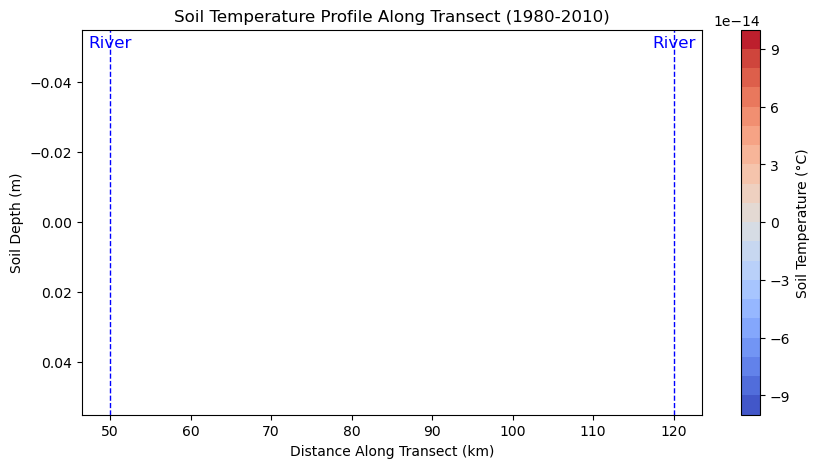

In [9]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Paths to dataset
file_path = "/glade/derecho/scratch/renatob/vic_alaska/output/cmip5_ensemble_eb_rcp45.nc"
variables = ["SOIL_TEMP1", "SOIL_TEMP2", "SOIL_TEMP3", "latitude", "longitude"]
ds = xr.open_dataset(file_path)[variables]

# Transect locations
stations = [
    {"name": "Tok", "lon": -142.8089, "lat": 63.3286},
    {"name": "Canol Trail", "lon": -130.98, "lat": 63.25},
]

# Buffer (25 km on each side)
buffer_km = 25
earth_radius_km = 6371  # Earth radius in km

# Soil depths (meters) — updated
depths = {
    "Surface (0.02042 m)": "SOIL_TEMP1",
    "Mid-depth (0.97047 m)": "SOIL_TEMP2",
    "Deep (2.0 m)": "SOIL_TEMP3",
}

# Function to get dataset along the transect area
def select_nearby_points(ds, lon1, lat1, lon2, lat2, buffer_km):
    lat_min = min(lat1, lat2) - (buffer_km / earth_radius_km) * (180 / np.pi)
    lat_max = max(lat1, lat2) + (buffer_km / earth_radius_km) * (180 / np.pi)
    lon_min = min(lon1, lon2) - (buffer_km / (earth_radius_km * np.cos(np.radians(lat1)))) * (180 / np.pi)
    lon_max = max(lon1, lon2) + (buffer_km / (earth_radius_km * np.cos(np.radians(lat1)))) * (180 / np.pi)

    # Compute boolean mask
    mask = ((ds.latitude >= lat_min) & (ds.latitude <= lat_max) &
            (ds.longitude >= lon_min) & (ds.longitude <= lon_max)).compute()

    return ds.where(mask, drop=True)

# Subset data for the transect region
ds_selected = select_nearby_points(ds, stations[0]["lon"], stations[0]["lat"], stations[1]["lon"], stations[1]["lat"], buffer_km)

# Compute mean temperature over the historical period (1980-2010)
ds_historical = ds_selected.sel(time=slice("1980-01-01", "2010-12-31")).mean(dim="time")

# Convert lat/lon to distance along transect
lons = ds_historical.longitude.values
lats = ds_historical.latitude.values
distances = np.sqrt((lons - stations[0]["lon"])**2 + (lats - stations[0]["lat"])**2) * 111  # Convert degrees to km

# Flatten arrays for interpolation
lon_flat = lons.flatten()
lat_flat = lats.flatten()
dist_flat = distances.flatten()

# Prepare temperature data
temperature_profiles = {depth: ds_historical[var].values.flatten() for depth, var in depths.items()}

# Set up vertical transect grid
x_grid = np.linspace(dist_flat.min(), dist_flat.max(), 100)  # Distance along the transect
y_grid = np.array([-0.02042, -0.97047, -2.0])  # Depths (negative for below ground)

# Interpolate temperatures onto the transect grid
temp_grid = np.zeros((len(y_grid), len(x_grid)))

for i, (depth, temp_values) in enumerate(temperature_profiles.items()):
    temp_grid[i, :] = griddata(dist_flat, temp_values, x_grid, method="linear")

# **Plot the Vertical Soil Temperature Profile**
fig, ax = plt.subplots(figsize=(10, 5))

# Contour plot
c = ax.contourf(x_grid, y_grid, temp_grid, cmap="coolwarm", levels=20)
cbar = plt.colorbar(c, ax=ax)
cbar.set_label("Soil Temperature (°C)")

# Add river positions (just an example, replace with actual locations)
river_positions = [50, 120]  # Example positions in km
for river_pos in river_positions:
    ax.axvline(river_pos, color="blue", linestyle="--", linewidth=1)
    ax.text(river_pos, -0.05, "River", color="blue", fontsize=12, ha="center")

# Labels and formatting
ax.set_xlabel("Distance Along Transect (km)")
ax.set_ylabel("Soil Depth (m)")
ax.set_title("Soil Temperature Profile Along Transect (1980-2010)")
ax.invert_yaxis()  # Depth increases downward
plt.show()


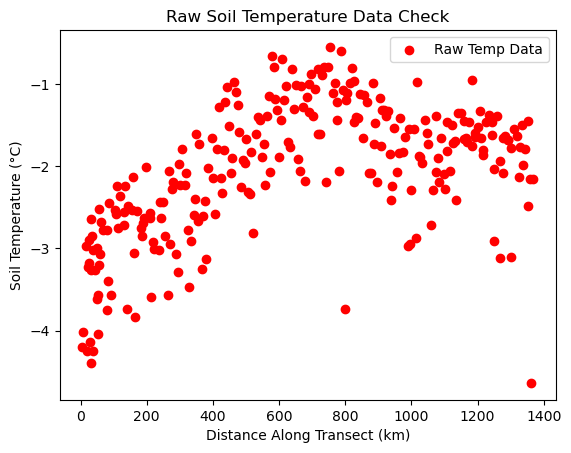

In [10]:
plt.scatter(dist_flat, temperature_profiles["Deep (2.0 m)"], color='red', label='Raw Temp Data')
plt.xlabel("Distance Along Transect (km)")
plt.ylabel("Soil Temperature (°C)")
plt.title("Raw Soil Temperature Data Check")
plt.legend()
plt.show()


In [11]:
from scipy.interpolate import griddata

# Create grid
grid_x, grid_y = np.meshgrid(
    np.linspace(min(dist_flat), max(dist_flat), 200),  # Increase resolution
    np.linspace(min(depths_meters), max(depths_meters), 50)
)

# Interpolate temperature values onto grid
grid_temp = griddata(
    (dist_flat, np.full_like(dist_flat, depths_meters[-1])),  # Only using last depth layer for now
    temperature_profiles["Deep (2.0 m)"],
    (grid_x, grid_y),
    method="linear"
)

# Plot
plt.figure(figsize=(10, 6))
plt.contourf(grid_x, grid_y, grid_temp, cmap="coolwarm", levels=20)
plt.colorbar(label="Soil Temperature (°C)")
plt.xlabel("Distance Along Transect (km)")
plt.ylabel("Soil Depth (m)")
plt.title("Soil Temperature Profile Along Transect (1980-2010)")
plt.gca().invert_yaxis()  # Depth should increase downward
plt.show()


NameError: name 'depths_meters' is not defined